## Imports and Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
from pathlib import Path
from time import time
from collections import deque
from datetime import datetime
from random import sample
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
sns.set_style('whitegrid')

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
tf.compat.v1.disable_eager_execution()

import gym
from gym.envs.registration import register

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


### Helper functions

In [5]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return '{:02.0f}:{:02.0f}:{:02.0f}'.format(h, m, s)

## Set up Gym Environment

In [6]:
trading_days = 252

In [7]:
register(
    id='trading-v0',
    entry_point='trading_env:TradingEnvironment',
    max_episode_steps=trading_days,
    kwargs={'trading_days': 252,
            'trading_cost_bps': 1e-3,
            'time_cost_bps': 1e-4,
            'ticker': 'MSFT'}
)

### Initialize Trading Environment

In [8]:
trading_environment = gym.make('trading-v0')
trading_environment.seed(42)

2020-11-16 18:24:25,513 INFO     trading_env logger started
2020-11-16 18:24:25,514 INFO     loading data for MSFT...


data already saved C:\Users\Jameshuckle\Dropbox\My-Portfolio\DataScience/data\SP500_all_stock_data_2000-01-01-2020-11-1.csv
[*********************100%***********************]  1 of 1 completed

2020-11-16 18:24:25,928 INFO     got data for MSFT...
2020-11-16 18:24:25,949 INFO     None



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5209 entries, 2000-02-18 to 2020-10-30
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   returns  5209 non-null   float64
 1   ret_2    5209 non-null   float64
 2   ret_5    5209 non-null   float64
 3   ret_10   5209 non-null   float64
 4   ret_21   5209 non-null   float64
 5   rsi      5209 non-null   float64
 6   macd     5209 non-null   float64
 7   atr      5209 non-null   float64
 8   stoch    5209 non-null   float64
 9   ultosc   5209 non-null   float64
dtypes: float64(10)
memory usage: 447.6 KB


[42]

In [29]:
#trading_environment.env.data_source.load_data()[['high','low','close']].plot()

### Get Environment params

In [19]:
state_dim = trading_environment.observation_space.shape[0]
num_actions = trading_environment.action_space.n
max_episode_steps = trading_environment.spec.max_episode_steps

## Define Trading Agent

In [20]:
class DDQNAgent:
    def __init__(self, state_dim, num_actions, learning_rate, gamma, epsilon_start,
                 epsilon_end, epsilon_decay_steps, epsilon_exponential_decay, replay_capacity,
                 architecture, l2_reg, tau, batch_size, train):
        
        self.state_dim = state_dim
        self.num_actions = num_actions
        self.experience = deque([], maxlen=replay_capacity)
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.architecture = architecture
        self.l2_reg = l2_reg
        
        self.online_network = self.build_model()
        self.target_network = self.build_model(trainable=False)
        self.update_target()
        
        self.epsilon = epsilon_start
        self.epsilon_decay_steps = epsilon_decay_steps
        self.epsilon_decay = (epsilon_start - epsilon_end) / epsilon_decay_steps
        self.epsilon_exponential_decay = epsilon_exponential_decay
        self.epsilon_history = []
        
        self.total_steps = self.train_steps = 0
        self.episodes = self.episode_length = self.train_episodes = 0
        self.steps_per_episode = []
        self.episode_reward = 0
        self.rewards_history = []
        
        self.batch_size = batch_size
        self.tau = tau
        self.losses = []
        self.idx = tf.range(batch_size)
        self.train = train
        
    
    def build_model(self, trainable=True):
        layers = []
        n = len(self.architecture)
        for i, units in enumerate(self.architecture, 1):
            layers.append(Dense(units=units,
                                input_dim=self.state_dim if i == 1 else None,
                                activation='relu',
                                kernel_regularizer=l2(self.l2_reg),
                                name=f'Dense_{i}',
                                trainable=trainable))
        layers.append(Dropout(.1))
        layers.append(Dense(units=self.num_actions,
                            trainable=trainable,
                            name='Output'))
        model = Sequential(layers)
        model.compile(loss='mean_squared_error',
                      optimizer=Adam(lr=self.learning_rate))
        return model
    
    def update_target(self):
        self.target_network.set_weights(self.online_network.get_weights())

    def epsilon_greedy_policy(self, state):
        self.total_steps += 1
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.num_actions)
        q = self.online_network.predict(state)
        return np.argmax(q, axis=1).squeeze()

    def memorize_transition(self, s, a, r, s_prime, not_done):
        if not_done:
            self.episode_reward += r
            self.episode_length += 1
        else:
            if self.train:
                if self.episodes < self.epsilon_decay_steps:
                    self.epsilon -= self.epsilon_decay
                else:
                    self.epsilon *= self.epsilon_exponential_decay

            self.episodes += 1
            self.rewards_history.append(self.episode_reward)
            self.steps_per_episode.append(self.episode_length)
            self.episode_reward, self.episode_length = 0, 0

        self.experience.append((s, a, r, s_prime, not_done))

    def experience_replay(self):
        if self.batch_size > len(self.experience):
            return
        minibatch = map(np.array, zip(*sample(self.experience, self.batch_size)))
        #minibatch = (np.array(i) for i in sample(self.experience, self.batch_size))
        states, actions, rewards, next_states, not_done = minibatch

        next_q_values = self.online_network.predict_on_batch(next_states)
        # best_actions = tf.argmax(next_q_values, axis=1) # original slow eager exc
        best_actions = np.argmax(next_q_values, axis=1)

        next_q_values_target = self.target_network.predict_on_batch(next_states)
        #  target_q_values = tf.gather_nd(
        #            next_q_values_target,
        #            tf.stack((self.idx, tf.cast(best_actions, tf.int32)), axis=1)) # original slow eacher exc
        target_q_values = next_q_values_target[range(len(next_q_values_target)), best_actions]

        targets = rewards + not_done * self.gamma * target_q_values

        q_values = self.online_network.predict_on_batch(states)
        #q_values[tuple([self.idx, actions])] = targets # original slow eager exc
        q_values[tuple([range(self.batch_size), actions])] = targets

        loss = self.online_network.train_on_batch(x=states, y=q_values)
        self.losses.append(loss)

        if self.total_steps % self.tau == 0:
            self.update_target()

## Define hyperparameters

In [21]:
gamma = .99 # discount factor
tau = 100 # target network update frequency

### NN Architecture
architecture = (256, 256) # units per layer
learning_rate = 1e-4 
l2_reg = 1e-6

### Experience Replay
replay_capacity = int(1e6)
batch_size = 4096

### e-greedy Policy
epsilon_start = 1.0
epsilon_end = .01
epsilon_decay_steps = 250
epsilon_exponential_decay = .99

## Create DDQN Agent (TF)

In [22]:
tf.keras.backend.clear_session()

train = False #set to False to test ddqn
ddqn = DDQNAgent(state_dim=state_dim,
                 num_actions=num_actions,
                 learning_rate=learning_rate,
                 gamma=gamma,
                 epsilon_start=epsilon_start,
                 epsilon_end=epsilon_end,
                 epsilon_decay_steps=epsilon_decay_steps,
                 epsilon_exponential_decay=epsilon_exponential_decay,
                 replay_capacity=replay_capacity,
                 architecture=architecture,
                 l2_reg=l2_reg,
                 tau=tau,
                 batch_size=batch_size,
                 train=train)

In [23]:
load_weights = True

if ddqn.train == False or load_weights:
    print('>>> loading weights')
    ddqn.online_network.load_weights(
        f'./results/trading_bot_2020-11-16_17-37/model_weights/model_weights')
    ddqn.update_target()
    if ddqn.train == False:
        ddqn.epsilon = 0

>>> loading weights


In [24]:
#ddqn.online_network.summary()

## Run Experiment

### Set parameters

In [25]:
total_steps = 0
max_episodes = 1000

### Initialize variables
episode_time, navs, market_navs, diffs, episode_eps = [], [], [], [], []

## Visualization

In [26]:
def track_results(episode, nav_ma_100, nav_ma_10, market_nav_100, market_nav_10,
                  win_ratio, total, epsilon):
    time_ma = np.mean([episode_time[-100:]])
    T = np.sum(episode_time)
    
    template = (f'{episode:>4d} | {format_time(total)} | '
                f'Agent: {nav_ma_100-1:>6.1%} ({nav_ma_10-1:>6.1%}) | '
                f'Market: {market_nav_100-1:>6.1%} ({market_nav_10-1:>6.1%}) | '
                f'Wins: {win_ratio:>5.1%} | eps: {epsilon:>6.3f}')
    print(template)

### Train Agent

In [27]:
start = time()
results = []
for episode in range(1, max_episodes + 1):
    this_state = trading_environment.reset()
    for episode_step in range(max_episode_steps):
        action = ddqn.epsilon_greedy_policy(this_state.reshape(-1, state_dim))
        next_state, reward, done, _ = trading_environment.step(action)
    
        ddqn.memorize_transition(this_state, 
                                 action, 
                                 reward, 
                                 next_state, 
                                 0.0 if done else 1.0)
        if ddqn.train:
            ddqn.experience_replay()
        if done:
            break
        this_state = next_state

    result = trading_environment.env.simulator.result()
    final = result.iloc[-1]

    nav = final.nav * (1 + final.strategy_return)
    navs.append(nav)

    market_nav = final.market_nav
    market_navs.append(market_nav)

    diff = nav - market_nav
    diffs.append(diff)
    if episode % 10 == 0:
        track_results(episode, np.mean(navs[-100:]), np.mean(navs[-10:]), 
                      np.mean(market_navs[-100:]), np.mean(market_navs[-10:]), 
                      np.sum([s > 0 for s in diffs[-100:]]) / min(len(diffs), 100), 
                      time() - start, ddqn.epsilon)
    if len(diffs) > 25 and all([r > 0 for r in diffs[-25:]]):
        print(result.tail())
        break

trading_environment.close()

  10 | 00:00:03 | Agent:  -4.9% ( -4.9%) | Market:  25.6% ( 25.6%) | Wins:  0.0% | eps:  0.000
  20 | 00:00:07 | Agent:   3.2% ( 11.3%) | Market:  23.7% ( 21.8%) | Wins: 10.0% | eps:  0.000
  30 | 00:00:10 | Agent:  -1.5% (-10.9%) | Market:  19.3% ( 10.5%) | Wins: 10.0% | eps:  0.000
  40 | 00:00:14 | Agent:  -1.8% ( -2.7%) | Market:  14.2% ( -1.3%) | Wins: 15.0% | eps:  0.000
  50 | 00:00:17 | Agent:  -2.2% ( -4.0%) | Market:  10.1% ( -5.9%) | Wins: 24.0% | eps:  0.000
  60 | 00:00:21 | Agent:  -1.8% (  0.3%) | Market:   9.2% (  4.6%) | Wins: 26.7% | eps:  0.000
  70 | 00:00:24 | Agent:  -1.4% (  1.1%) | Market:   8.7% (  5.6%) | Wins: 27.1% | eps:  0.000
  80 | 00:00:28 | Agent:  -1.1% (  1.1%) | Market:   8.3% (  5.5%) | Wins: 27.5% | eps:  0.000
  90 | 00:00:31 | Agent:  -2.0% ( -9.3%) | Market:   8.7% ( 11.7%) | Wins: 26.7% | eps:  0.000
 100 | 00:00:35 | Agent:  -2.3% ( -5.3%) | Market:   8.1% (  3.0%) | Wins: 26.0% | eps:  0.000
 110 | 00:00:38 | Agent:  -2.4% ( -5.4%) | Market:

2020-11-16 19:09:24,173 WARNING  Unresolved object in checkpoint: (root).optimizer.iter


2020-11-16 19:09:24,175 WARNING  Unresolved object in checkpoint: (root).optimizer.beta_1


2020-11-16 19:09:24,176 WARNING  Unresolved object in checkpoint: (root).optimizer.beta_2


2020-11-16 19:09:24,178 WARNING  Unresolved object in checkpoint: (root).optimizer.decay


2020-11-16 19:09:24,179 WARNING  Unresolved object in checkpoint: (root).optimizer.learning_rate


2020-11-16 19:09:24,180 WARNING  Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-0.kernel


2020-11-16 19:09:24,181 WARNING  Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-0.bias


2020-11-16 19:09:24,181 WARNING  Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.kernel


2020-11-16 19:09:24,182 WARNING  Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.bias


2020-11-16 19:09:24,183 WARNING  Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.kernel


2020-11-16 19:09:24,185 WARNING  Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.bias


2020-11-16 19:09:24,186 WARNING  Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-0.kernel


2020-11-16 19:09:24,187 WARNING  Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-0.bias


2020-11-16 19:09:24,188 WARNING  Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.kernel


2020-11-16 19:09:24,190 WARNING  Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.bias


2020-11-16 19:09:24,191 WARNING  Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.kernel


2020-11-16 19:09:24,192 WARNING  Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.bias


2020-11-16 19:09:24,193 WARNING  A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/guide/checkpoint#loading_mechanics for details.


 750 | 00:04:23 | Agent:  -7.6% ( -3.6%) | Market:   7.8% (  2.8%) | Wins: 22.0% | eps:  0.000
 760 | 00:04:26 | Agent:  -7.9% (-12.2%) | Market:   6.8% (  7.6%) | Wins: 21.0% | eps:  0.000
 770 | 00:04:30 | Agent:  -7.4% (-11.0%) | Market:   6.4% ( 13.3%) | Wins: 22.0% | eps:  0.000
 780 | 00:04:33 | Agent:  -8.0% (-21.5%) | Market:   5.4% ( -0.4%) | Wins: 22.0% | eps:  0.000
 790 | 00:04:37 | Agent:  -8.5% (-16.6%) | Market:   6.6% ( 12.1%) | Wins: 21.0% | eps:  0.000
 800 | 00:04:40 | Agent: -10.1% (-10.1%) | Market:   7.6% ( 14.2%) | Wins: 19.0% | eps:  0.000
 810 | 00:04:43 | Agent: -11.3% (-13.2%) | Market:   6.7% ( 12.8%) | Wins: 19.0% | eps:  0.000
 820 | 00:04:47 | Agent: -11.9% (-16.8%) | Market:   7.1% (  1.9%) | Wins: 18.0% | eps:  0.000
 830 | 00:04:50 | Agent: -11.4% ( -5.7%) | Market:   8.1% ( 15.6%) | Wins: 18.0% | eps:  0.000
 840 | 00:04:53 | Agent: -11.9% ( -8.6%) | Market:   9.8% ( 18.3%) | Wins: 15.0% | eps:  0.000
 850 | 00:04:57 | Agent: -12.7% (-10.9%) | Market:

### Store Results

In [68]:
save = False
if save:
    date_now = datetime.now().strftime('%Y-%m-%d_%H-%M')
    results_path = Path('results', f'trading_bot_{date_now}')
    if not results_path.exists():
        results_path.mkdir(parents=True)
        
    ddqn.online_network.save_weights(f'{results_path}/model_weights/model_weights')

In [69]:
results = pd.DataFrame({'Episode': list(range(1, episode+1)),
                        'Agent': navs,
                        'Market': market_navs,
                        'Difference': diffs}).set_index('Episode')

results['Strategy Wins (%)'] = (results.Difference > 0).rolling(100).sum()
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1 to 1000
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Agent              1000 non-null   float64
 1   Market             1000 non-null   float64
 2   Difference         1000 non-null   float64
 3   Strategy Wins (%)  901 non-null    float64
dtypes: float64(4)
memory usage: 39.1 KB


In [70]:
if save:
    results.to_csv(results_path / f'results.csv', index=False)

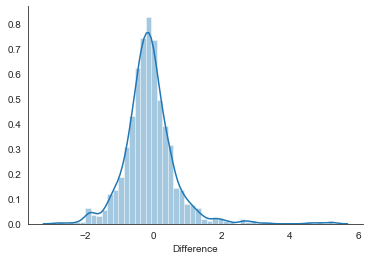

In [71]:
with sns.axes_style('white'):
    sns.distplot(results.Difference)
    sns.despine()

### Evaluate results

In [72]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1 to 1000
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Agent              1000 non-null   float64
 1   Market             1000 non-null   float64
 2   Difference         1000 non-null   float64
 3   Strategy Wins (%)  901 non-null    float64
dtypes: float64(4)
memory usage: 39.1 KB


The following diagram shows the rolling average of agent and market returns over 100 periods on the left, and the share of the last 100 periods the agent outperformed the market on the right. It uses AAPL stock data for which there are some 9,000 daily price and volume observations. Training stopped after 14,000 trading periods when the agent beat the market 10 consecutive times.

It shows how the agent's performance improves significantly while exploring at a higher rate over the first ~3,000 periods (that is, years) and approaches a level where it outperforms the market around 40 percent of the time, despite transaction costs. In a few instances, it beats the market about half the time out of 100 periods:

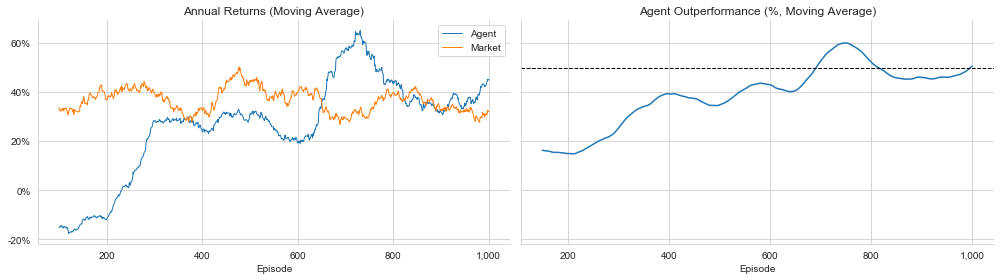

In [73]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True)

df1 = (results[['Agent', 'Market']]
       .sub(1)
       .rolling(100)
       .mean())
df1.plot(ax=axes[0],
         title='Annual Returns (Moving Average)',
         lw=1)

df2 = results['Strategy Wins (%)'].div(100).rolling(50).mean()
df2.plot(ax=axes[1],
         title='Agent Outperformance (%, Moving Average)')

for ax in axes:
    ax.yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    ax.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))
axes[1].axhline(.5, ls='--', c='k', lw=1)

sns.despine()
fig.tight_layout()
if save:
    fig.savefig(results_path / 'performance', dpi=300)

## Things to do
- Format input data to sliding window to incorporate more data / features
- Use an LSTM rather an DNN